In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject5.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Feed Forward Neural Network with Only Blood Glucose

In [6]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7549/7549 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 4493.4419 - mae: 43.1323 - val_loss: 436.0642 - val_mae: 14.9931
Epoch 2/5
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1010.0511 - mae: 24.1313 - val_loss: 368.6660 - val_mae: 13.5668
Epoch 3/5
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 941.5974 - mae: 23.2189 - val_loss: 353.2959 - val_mae: 13.2297
Epoch 4/5
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 904.3487 - mae: 22.5623 - val_loss: 366.2909 - val_mae: 13.5631
Epoch 5/5
7549/7549 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 861.5673 - mae: 21.9178 - val_loss: 332.4839 - val_mae: 12.7307
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 251.6418 - mae: 10.9967
Test Loss: 272.1849670410156, Test MAE: 11.377559661865234
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 16.498031243342453


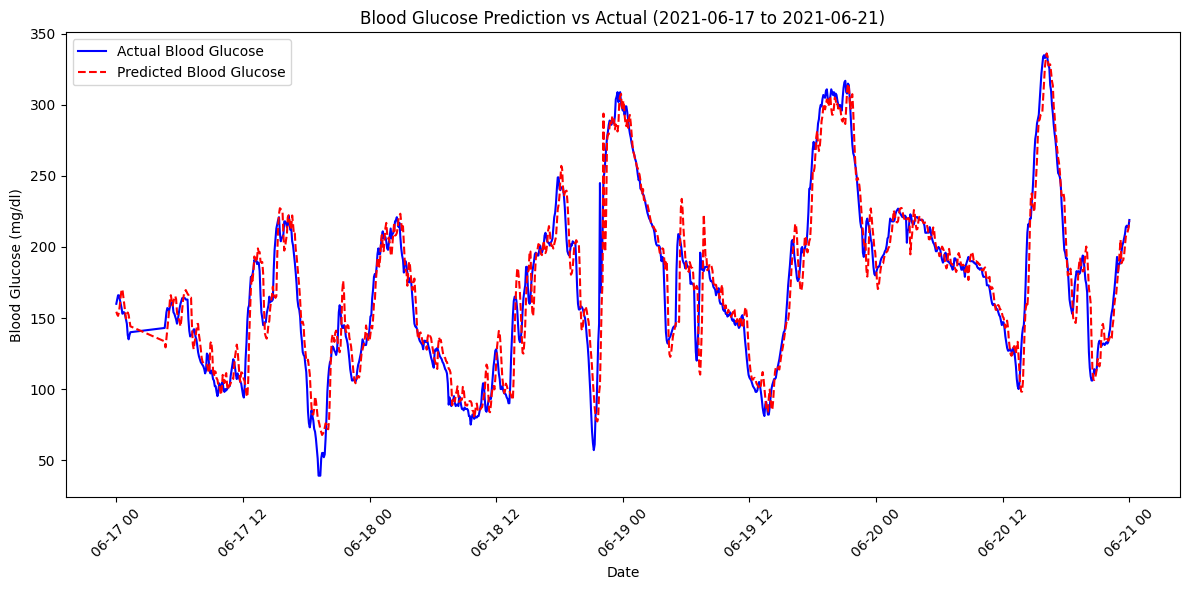

In [8]:
import matplotlib.pyplot as plt

# Add 'date' to the test data for plotting
test_dates = cgm_data['date'][train_size:].reset_index(drop=True)

# Function to plot actual vs predicted values for a specific week
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    # Create a DataFrame for easier manipulation
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    # Filter data for the given date range
    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify the start and end date for the week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions for the specified week
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)


6

In [9]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7548/7548 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 5313.5801 - mae: 49.7325 - val_loss: 869.0380 - val_mae: 21.6167
Epoch 2/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1562.3446 - mae: 30.3174 - val_loss: 861.4189 - val_mae: 21.7120
Epoch 3/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 1484.4056 - mae: 29.4861 - val_loss: 778.7519 - val_mae: 20.3571
Epoch 4/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1418.2242 - mae: 28.7535 - val_loss: 754.1014 - val_mae: 20.1057
Epoch 5/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1360.4384 - mae: 28.1113 - val_loss: 756.7534 - val_mae: 20.1764
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 585.4756 - mae: 17.5407
Test Loss: 622.8226318359375, Test MAE: 18.12885856628418
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 24.956423406471743


9

In [12]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7548/7548 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 5030.0811 - mae: 49.4766 - val_loss: 1402.3011 - val_mae: 28.3290
Epoch 2/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1817.9209 - mae: 32.9047 - val_loss: 1364.0442 - val_mae: 27.9311
Epoch 3/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1708.3802 - mae: 31.7698 - val_loss: 1216.8212 - val_mae: 26.1526
Epoch 4/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1657.6206 - mae: 31.3339 - val_loss: 1244.6348 - val_mae: 26.4090
Epoch 5/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1617.7032 - mae: 30.8838 - val_loss: 1227.1278 - val_mae: 26.2617
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 956.4413 - mae: 23.0431
Test Loss: 1019.5538330078125, Test MAE: 23.805065155029297
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 31.93044948077514


12

In [15]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7548/7548 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 5724.5898 - mae: 54.0626 - val_loss: 1841.6965 - val_mae: 32.8414
Epoch 2/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 2232.7881 - mae: 36.8289 - val_loss: 1772.0088 - val_mae: 32.1230
Epoch 3/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2135.6208 - mae: 35.9203 - val_loss: 1806.8694 - val_mae: 32.5667
Epoch 4/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2084.0703 - mae: 35.3674 - val_loss: 1748.6997 - val_mae: 31.8895
Epoch 5/5
7548/7548 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 2011.3719 - mae: 34.6891 - val_loss: 1683.8373 - val_mae: 31.2135
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1303.1952 - mae: 27.3500
Test Loss: 1399.36669921875, Test MAE: 28.309066772460938
2359/2359 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 37.40810095046523


Feed Forward Neural Network with Blood Glucose and Bolus

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load CGM and Bolus data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

In [19]:
# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM (past glucose readings)
num_lags = 12  # Number of past readings to use
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [20]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 3  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-20-2e8ff43a49a4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [21]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 3358.9441 - mae: 36.9993 - val_loss: 507.3633 - val_mae: 15.8199
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1047.2095 - mae: 23.9754 - val_loss: 452.7311 - val_mae: 14.7263
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 990.6165 - mae: 23.2245 - val_loss: 440.3968 - val_mae: 14.4841
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 947.0104 - mae: 22.5544 - val_loss: 409.5564 - val_mae: 13.9166
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 890.9816 - mae: 21.8083 - val_loss: 410.2543 - val_mae: 13.8154
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 367.0757 - mae: 13.2702
Test Loss: 383.6588439941406, Test MAE: 13.536527633666992
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Root Mean Squared Error (RMSE): 19.58720529941199


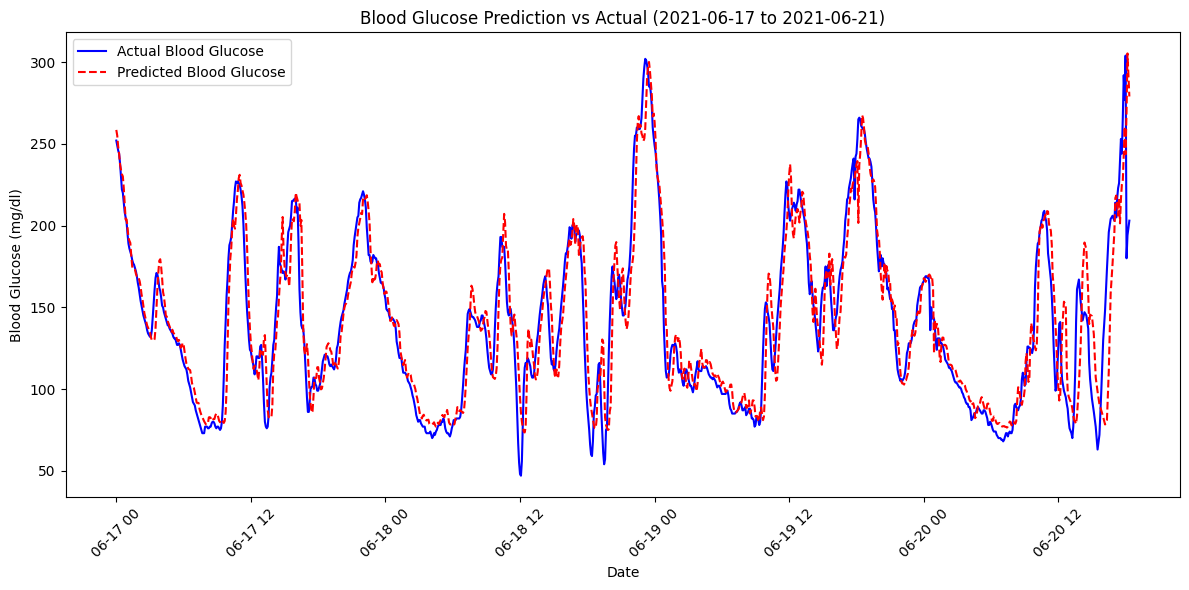

In [22]:
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [23]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 6  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 3578.1484 - mae: 40.2343 - val_loss: 975.1282 - val_mae: 22.0537
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 1473.0957 - mae: 28.5204 - val_loss: 954.5499 - val_mae: 21.9261
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1430.6084 - mae: 27.9802 - val_loss: 933.8902 - val_mae: 21.4494
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1376.3324 - mae: 27.3842 - val_loss: 927.5806 - val_mae: 21.5762
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1333.1853 - mae: 26.9151 - val_loss: 890.6273 - val_mae: 20.9866
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 819.1936 - mae: 20.3496
Test Loss: 832.5681762695312, Test MAE: 20.642358779907227
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Root Mean Squared Error (RMSE): 28.854264225371658


9

In [25]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 9  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 4182.0361 - mae: 45.4723 - val_loss: 1622.6431 - val_mae: 29.6075
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 2063.5693 - mae: 34.2461 - val_loss: 1596.6656 - val_mae: 29.3497
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2008.2950 - mae: 33.6944 - val_loss: 1562.1622 - val_mae: 28.9008
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1956.5526 - mae: 33.2555 - val_loss: 1630.0822 - val_mae: 30.0765
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 1920.1180 - mae: 32.9122 - val_loss: 1518.6145 - val_mae: 28.4503
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1385.5125 - mae: 27.2492
Test Loss: 1361.7156982421875, Test MAE: 27.014854431152344
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 36.90142403078505


12

In [27]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 12  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 4946.7759 - mae: 50.4666 - val_loss: 2125.7622 - val_mae: 34.7554
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 2645.6956 - mae: 39.2464 - val_loss: 2076.5657 - val_mae: 33.9874
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 2571.2695 - mae: 38.5293 - val_loss: 2052.3877 - val_mae: 33.7430
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2517.5068 - mae: 38.0931 - val_loss: 2097.2695 - val_mae: 34.3178
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 2486.8352 - mae: 37.7994 - val_loss: 2101.4397 - val_mae: 34.2810
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1907.0082 - mae: 32.5931
Test Loss: 1825.2850341796875, Test MAE: 31.833303451538086
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Root Mean Squared Error (RMSE): 42.723345621692836


LSTM with Blood Glucose and Bolus Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load CGM and Bolus data (same preprocessing steps as before)
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM and Bolus variables
num_lags = 12
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)



<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [30]:
# Generate target variable
forecast_horizon = 3
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-30-4728be9a6491>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [31]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 15ms/step - loss: 18620.6230 - mae: 113.7421 - val_loss: 1788.7004 - val_mae: 27.8843
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1212.7803 - mae: 24.0304 - val_loss: 513.6049 - val_mae: 15.4615
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 749.3133 - mae: 19.8262 - val_loss: 454.0237 - val_mae: 14.6804
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 721.3841 - mae: 19.4098 - val_loss: 400.6539 - val_mae: 13.3181
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 135s 15ms/step - loss: 703.8459 - mae: 19.1503 - val_loss: 404.3971 - val_mae: 13.2714
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - loss: 684.1804 - mae: 18.8720 - val_loss: 423.4471 - val_mae: 14.7428
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - loss: 677.0408 - mae: 18.7057 - val_loss: 386.9752 - val_mae: 13.3599
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - loss: 668.4039 - mae: 18.5658 - v

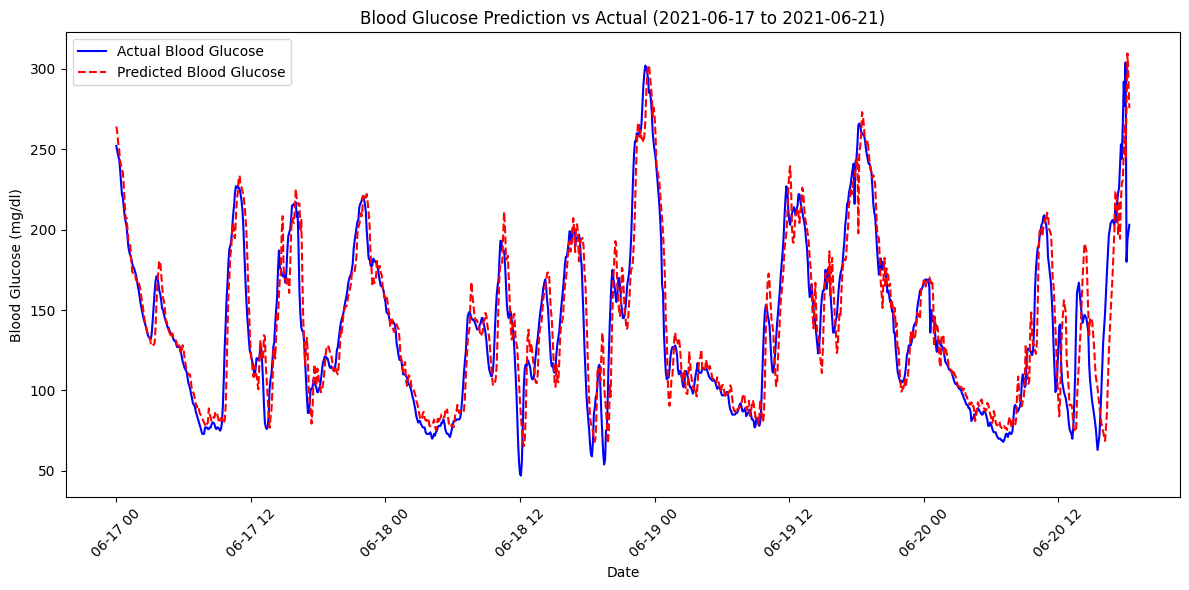

In [32]:
# Plot predictions vs actual for a given week
test_dates = merged_data['date'][train_size:].reset_index(drop=True)

def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [33]:
# Generate target variable
forecast_horizon = 6
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 135s 15ms/step - loss: 18843.8867 - mae: 115.0141 - val_loss: 2209.2793 - val_mae: 33.6678
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - loss: 1676.9866 - mae: 29.7296 - val_loss: 1072.3390 - val_mae: 24.7401
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 1259.4496 - mae: 26.0970 - val_loss: 906.8658 - val_mae: 20.9531
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - loss: 1215.6233 - mae: 25.5960 - val_loss: 903.8515 - val_mae: 21.2122
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 15ms/step - loss: 1195.9935 - mae: 25.3404 - val_loss: 1049.5355 - val_mae: 23.6124
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 133s 15ms/step - loss: 1181.7697 - mae: 25.1131 - val_loss: 861.4140 - val_mae: 20.2967
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 131s 15ms/step - loss: 1165.9316 - mae: 24.9528 - val_loss: 909.2791 - val_mae: 21.5397
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 153s 16ms/step - loss: 1157.4363 - mae: 24.

9

In [35]:
# Generate target variable
forecast_horizon = 9
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 16ms/step - loss: 18614.8262 - mae: 114.6896 - val_loss: 3351.8420 - val_mae: 43.3570
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 2394.8555 - mae: 36.5018 - val_loss: 1538.5808 - val_mae: 28.5915
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1776.0541 - mae: 31.4415 - val_loss: 1452.3805 - val_mae: 27.4839
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 1744.8693 - mae: 31.0690 - val_loss: 1445.0159 - val_mae: 27.2632
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - loss: 1730.7853 - mae: 30.9474 - val_loss: 1489.8864 - val_mae: 28.1528
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 1703.1099 - mae: 30.6985 - val_loss: 1415.9307 - val_mae: 27.1720
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 130s 15ms/step - loss: 1692.7950 - mae: 30.4774 - val_loss: 1423.9447 - val_mae: 27.1117
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 1690.2596 - mae:

12

In [37]:
# Generate target variable
forecast_horizon = 12
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 18740.8359 - mae: 114.8434 - val_loss: 3135.0662 - val_mae: 42.5845
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 127s 14ms/step - loss: 2652.9717 - mae: 39.1808 - val_loss: 2096.7664 - val_mae: 33.5264
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - loss: 2320.9412 - mae: 36.4715 - val_loss: 2032.1202 - val_mae: 34.1978
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 14ms/step - loss: 2269.2627 - mae: 36.0698 - val_loss: 1992.8214 - val_mae: 33.0901
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - loss: 2254.5713 - mae: 35.8533 - val_loss: 1982.6433 - val_mae: 33.2340
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 15ms/step - loss: 2240.5496 - mae: 35.7451 - val_loss: 2112.6738 - val_mae: 34.4171
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - loss: 2221.9624 - mae: 35.5612 - val_loss: 1969.2603 - val_mae: 32.8971
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 2205.8550 - mae:

CNN

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)



<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [40]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 123s 13ms/step - loss: 2541.6445 - mae: 33.9297 - val_loss: 546.7889 - val_mae: 16.3732
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - loss: 1001.5833 - mae: 23.2712 - val_loss: 640.0649 - val_mae: 18.8432
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 122s 14ms/step - loss: 958.3981 - mae: 22.7410 - val_loss: 820.6371 - val_mae: 22.4578
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 116s 13ms/step - loss: 939.9242 - mae: 22.5003 - val_loss: 750.9684 - val_mae: 21.0177
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 117s 13ms/step - loss: 936.1398 - mae: 22.3981 - val_loss: 890.7432 - val_mae: 23.3833
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1585.4742 - mae: 25.3230
Test Loss: 4293.53759765625, Test MAE: 36.53800582885742
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Root Mean Squared Error (RMSE): 65.52509121832685


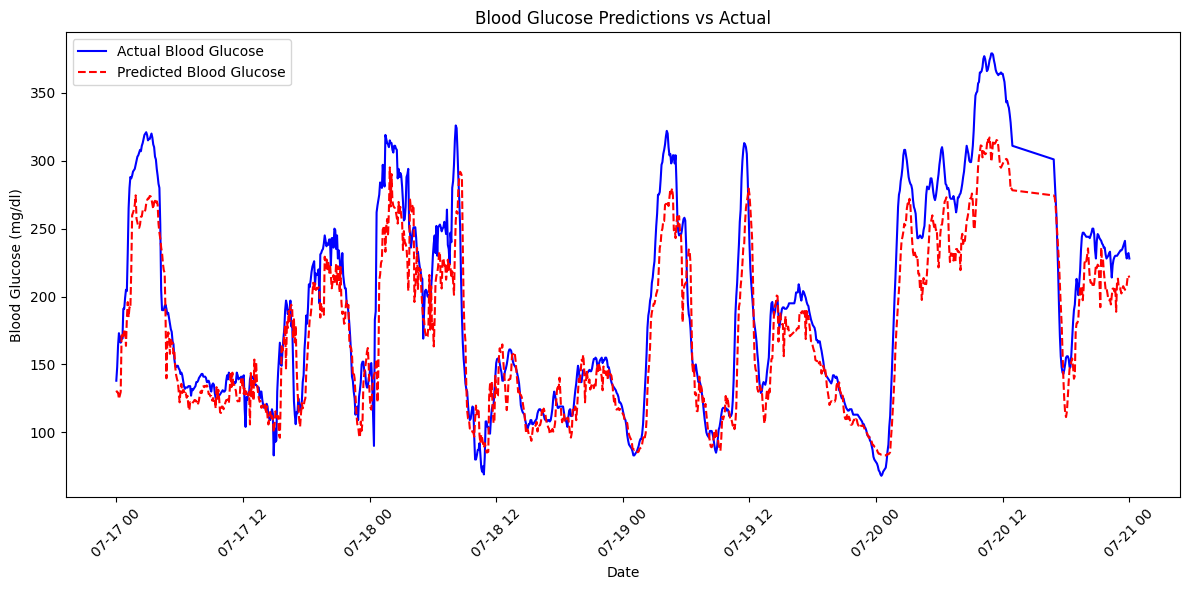

In [42]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')

6

In [43]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 115s 13ms/step - loss: 3031.9158 - mae: 38.7777 - val_loss: 1341.6029 - val_mae: 27.6850
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 13ms/step - loss: 1532.8143 - mae: 29.0767 - val_loss: 1114.3141 - val_mae: 24.3845
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 13ms/step - loss: 1453.0953 - mae: 28.3022 - val_loss: 1038.1832 - val_mae: 23.5629
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 14ms/step - loss: 1423.9580 - mae: 28.0346 - val_loss: 1218.6847 - val_mae: 25.9178
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 13ms/step - loss: 1402.3409 - mae: 27.7917 - val_loss: 1655.0570 - val_mae: 31.7203
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 4609.8350 - mae: 37.1490
Test Loss: 15461.1435546875, Test MAE: 62.343807220458984
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Root Mean Squared Error (RMSE): 124.34286116709767


9

In [45]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [46]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 123s 14ms/step - loss: 3535.4993 - mae: 43.2015 - val_loss: 1838.6677 - val_mae: 32.1085
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 113s 13ms/step - loss: 2055.1140 - mae: 34.0958 - val_loss: 1778.3097 - val_mae: 31.8696
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 13ms/step - loss: 1981.7621 - mae: 33.4514 - val_loss: 1719.3019 - val_mae: 31.2257
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 13ms/step - loss: 1938.7678 - mae: 33.0108 - val_loss: 1750.1155 - val_mae: 31.3363
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 13ms/step - loss: 1924.8702 - mae: 32.9071 - val_loss: 2480.2244 - val_mae: 39.3478
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 3970.3521 - mae: 41.9351
Test Loss: 9801.6240234375, Test MAE: 57.955169677734375
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Root Mean Squared Error (RMSE): 99.00319032118254


12

In [47]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 117s 13ms/step - loss: 4055.5769 - mae: 47.3452 - val_loss: 2548.7751 - val_mae: 38.7959
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 117s 13ms/step - loss: 2617.0051 - mae: 39.1602 - val_loss: 2255.2466 - val_mae: 35.7825
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 113s 13ms/step - loss: 2549.1370 - mae: 38.5043 - val_loss: 2249.5850 - val_mae: 35.8971
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 13ms/step - loss: 2483.5332 - mae: 37.8589 - val_loss: 2615.3110 - val_mae: 39.4502
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 13ms/step - loss: 2463.6860 - mae: 37.8294 - val_loss: 2973.9226 - val_mae: 42.7746
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 5687.5825 - mae: 46.6320
Test Loss: 16022.8994140625, Test MAE: 69.07650756835938
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
Root Mean Squared Error (RMSE): 126.58156491638032


CRNN

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for RCNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [50]:
# Build RCNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 345s 39ms/step - loss: 7215.0645 - mae: 66.6933 - val_loss: 5099.2148 - val_mae: 58.6572
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 379s 38ms/step - loss: 5069.1436 - mae: 57.8242 - val_loss: 5166.5029 - val_mae: 58.8942
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 373s 37ms/step - loss: 5031.0435 - mae: 57.7306 - val_loss: 5036.1045 - val_mae: 58.4506
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 382s 37ms/step - loss: 4984.4097 - mae: 57.4166 - val_loss: 5159.9082 - val_mae: 58.8705
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 331s 37ms/step - loss: 4948.3867 - mae: 57.3057 - val_loss: 5242.4214 - val_mae: 59.1759
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 4454.6709 - mae: 53.9668
Test Loss: 3847.40673828125, Test MAE: 50.323211669921875
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step
Root Mean Squared Error (RMSE): 62.027453121382266


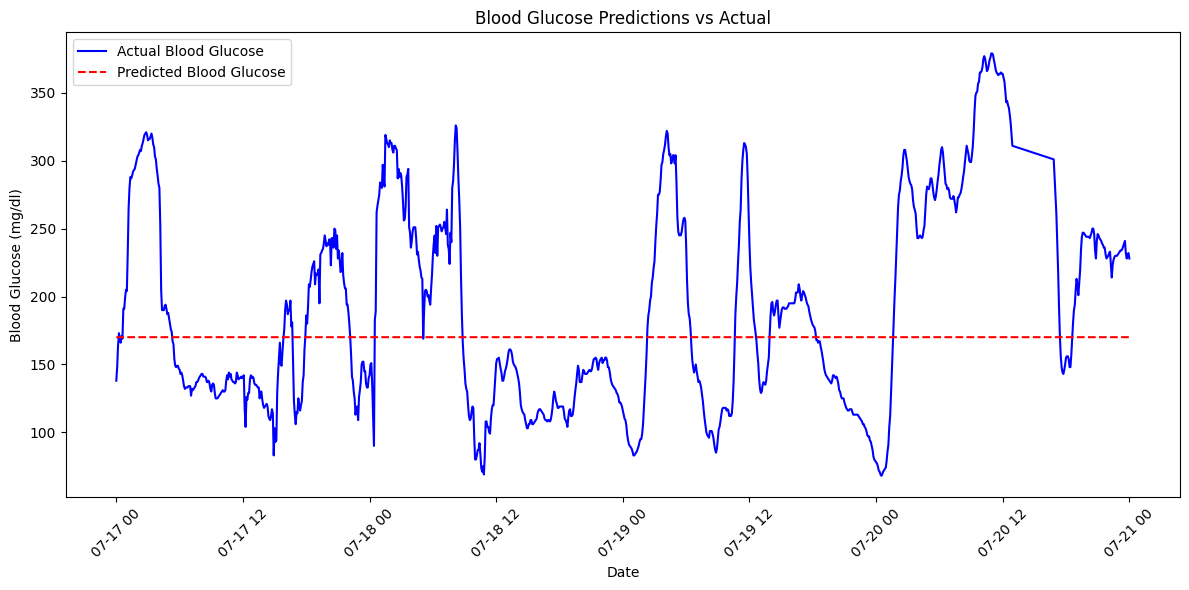

In [51]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')